### Multi-colinearity

If we have a linear model
$$
y = \beta_0 + \beta_1 x_1 + \ldots + \beta_n x_p + \epsilon
$$
and $n$ observations $y_i$ and $x_{i1}, x_{i2}, \ldots, x_{ip}$ we can estimate the co-efficients $\beta$ by solving
$$
Y = X \beta
$$
Where $X = x_ij$ is an $n \times p$ matrix and $Y$ and $\beta$ are the vectors of observations and parameters. Because linear algebra routines work best with symmetric matrices we premultiply by $X^T$ and solve to get
$$
\beta = (X^T X)^{-1} X^T Y
$$

Now is there is a linear relationship between parameters e.g.
$$
x_2 = \lambda_0 + \lambda_1 x_1
$$
Then the matrix $X^T X$ doesn't have full rank and can't be inverted. In practice, say we were predicting education outcomes based on yearly and monthly salary where $\text{yearly} = 12 \times \text{monthly}$. Obviously yearly and monthly are not independent pieces of information and in practice we would just delete one of the variables. More interesting (and troublesome) is the case where
$$
x_2 \simeq \lambda_0 + \lambda_1 x_1
$$
e.g. if $\text{yearly} \simeq 12 \times \text{monthly}$ where yearly salary could be higher (due to bonuses) or lower (due to strikes) or just different (swapping jobs mid year). This is the case of approximate multi-collinearity which causes many headaches in practice...

/home/ra414/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


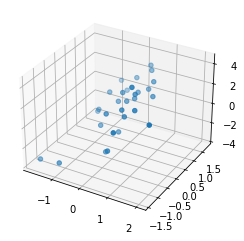

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

x = np.random.normal(0,1,30)
y = np.random.normal(0,1,30)
z = 2*x + y + np.random.normal(0,1,30)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)

plt.show()

Let's introduce some "nuisance" parameters and do some fits

In [2]:
n1 = np.random.normal(0,1,30)
n2 = -x + np.random.normal(0,0.01,30)
n3 = x + 0.5*y + np.random.normal(0,0.005,30)
Xmin = pd.DataFrame({"x":x, "y":y})
X = pd.DataFrame({"x":x, "y":y, "n1":n1, "n2":n2, "n3":n3})
Z = pd.DataFrame({"z":z})

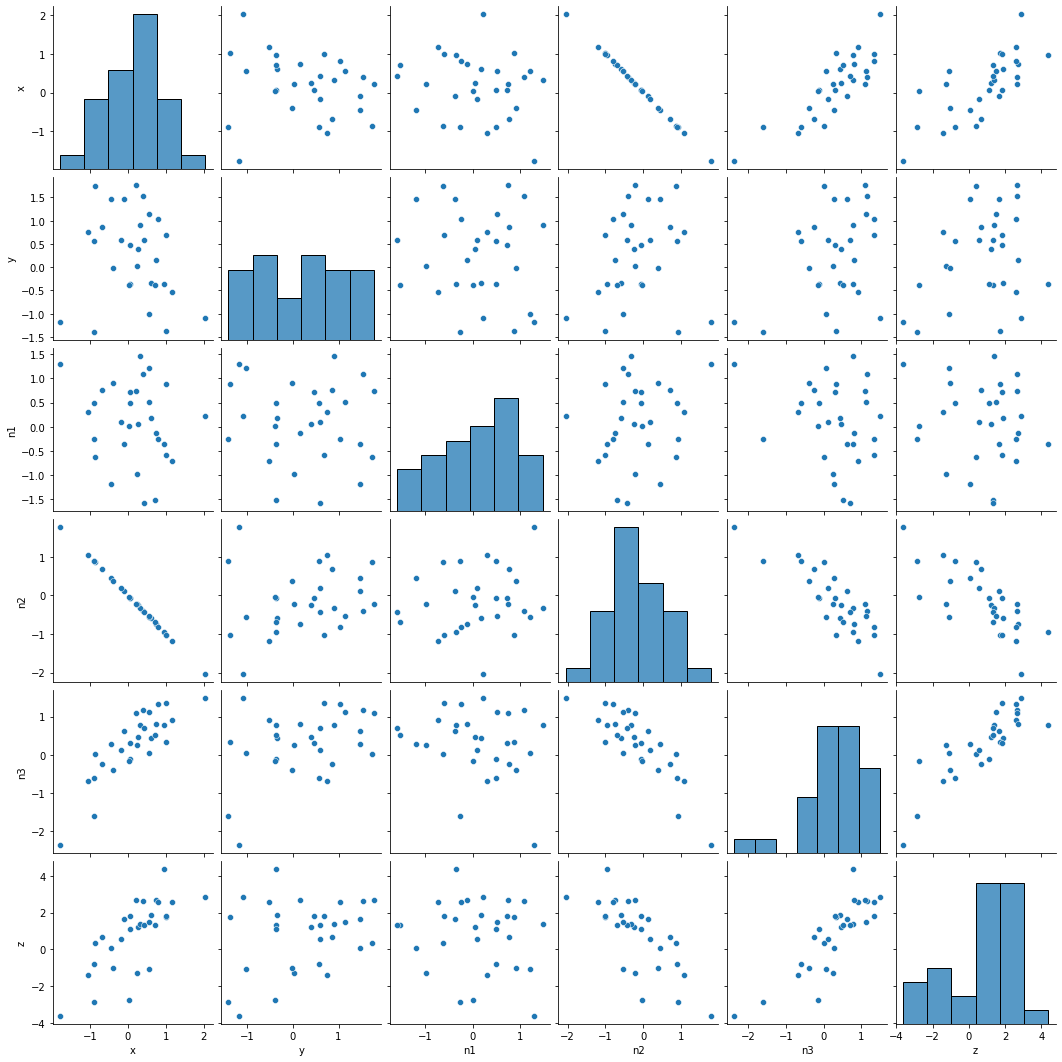

In [3]:
sns.pairplot( X.merge(Z, left_index=True, right_index=True) )

<AxesSubplot:>

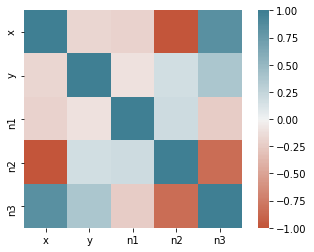

In [4]:
sns.heatmap(
    X.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [5]:
model = sm.OLS(z, Xmin).fit()
print( model.summary() )

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.750
Model:                            OLS   Adj. R-squared (uncentered):              0.733
Method:                 Least Squares   F-statistic:                              42.10
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                    3.63e-09
Time:                        08:57:15   Log-Likelihood:                         -43.116
No. Observations:                  30   AIC:                                      90.23
Df Residuals:                      28   BIC:                                      93.03
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [6]:
model = sm.OLS(z, X).fit()
print( model.summary() )

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.764
Model:                            OLS   Adj. R-squared (uncentered):              0.717
Method:                 Least Squares   F-statistic:                              16.21
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                    3.79e-07
Time:                        08:57:15   Log-Likelihood:                         -42.262
No. Observations:                  30   AIC:                                      94.52
Df Residuals:                      25   BIC:                                      101.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Compare these results
 - The R squared is the same (more or less)! So with or without the nuisance parameters we do an equally good job predicting the outcome.
 - But look at the coefficient values, none of them are significant! This is a tell tale sign of multi-colinearity. 
 
In bigger analyses this could happen on a subset of variables. Other signs are
  - See if there is a significant coefficient for the regression of one predictor on the outcome. If there is, but this vanishes when it's put in a multiple regression, you have problems.
  - Individual coefficients fail the significance tests, but they pass a joint test (F-test) for significance. Though could be a pain to do in practice (how do you group the variables?)

In [7]:
## Check each coeff individually
for p in X:
    model = sm.OLS(z, X[p]).fit()
    print("coeff", model.params,  "\npvalue", model.pvalues)

## Do the joint significance test
model = sm.OLS(z, X).fit()
A = np.identity(len(model.params)) ##confusing, see the docs https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.f_test.html
print(model.f_test(A))   
print(model.fvalue, model.f_pvalue)

coeff x    1.882081
dtype: float64 
pvalue x    0.000002
dtype: float64
coeff y    0.769182
dtype: float64 
pvalue y    0.045521
dtype: float64
coeff n1   -0.188461
dtype: float64 
pvalue n1    0.689619
dtype: float64
coeff n2   -1.879584
dtype: float64 
pvalue n2    0.000002
dtype: float64
coeff n3    1.99024
dtype: float64 
pvalue n3    3.021894e-10
dtype: float64
<F test: F=16.208189296811135, p=3.7940500520411553e-07, df_denom=25, df_num=5>
16.208189296807905 3.794050052048133e-07


So here we find each coefficient (apart from n1) is individually statistically significant. Comapre that to the model summary above where none of the were. We also find that they are together jointly significant under the F-test. Again, contrast this with the fact that none of the individual coefficients are distinguishable from 0 in the model summary.

### Principle Component Regression

We can decompose the data matrix $X$ into principle components
$$
X = U \Delta V^T
$$
For orthogonal $U$ and $V$ and diagonal $\Delta$. This transforms the normal matrix to
$$
X^T X = V \Lambda V^T
$$
Where $\Lambda = \Delta^2$ is the diagonal matrix of (real) eigenvalues of $X^TX$. If we keep only the top $K$ eigenvalues this is a rank $K$ approximation to the matrix.

Basically this is a "dimensional reduction" where we try to get rid of redundant information.

[5.71146533e-01 2.49757240e-01 1.79075053e-01 1.82530664e-05
 2.92179568e-06]


<BarContainer object of 5 artists>

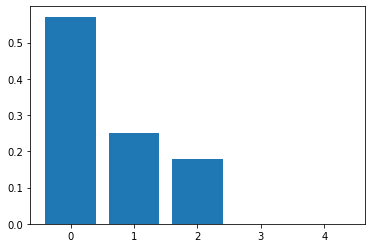

In [8]:
data = X.to_numpy()

##First center and normalise the data - this matters!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)

from sklearn.decomposition import PCA
pca = PCA() ##compute the full PCA. Save time in practice using n_components=K!
pca.fit(data)

print(pca.explained_variance_ratio_)
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)


Only the first 3 coefficients explain any significant variance. So let's use those to do the regression.

In [9]:
##Waste time recomputing the PCA because it's simpler than doing the maths myself
pca = PCA(n_components=3) 
data_pca = pca.fit_transform(data)
Xpca = pd.DataFrame({"pc0":data_pca[:,0], "pc1":data_pca[:,1], "pc2":data_pca[:,2] })

##Now do the fit
model = sm.OLS(z, Xpca).fit()
print( model.summary() )

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.613
Model:                            OLS   Adj. R-squared (uncentered):              0.570
Method:                 Least Squares   F-statistic:                              14.23
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                    9.37e-06
Time:                        08:57:16   Log-Likelihood:                         -49.710
No. Observations:                  30   AIC:                                      105.4
Df Residuals:                      27   BIC:                                      109.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

This is as it should be - there are two coefficients with significant predictive power (pc0 and pc1) and one coefficient without any (pc2). The problem is that we don't know what they are in terms of our original variables! They are some complicated linear combinations
$$
pc = c_1 x_1 + c_2 x_2 + \ldots c_p x_p
$$

Often in fact, the principle components can be reinterpreted as measuring something completely different than the input data. For example, when you do this kind of analysis on genetic data, using only the first two components, rather than thinking of them as measuring something genetic it is better to think of them as measuring latitude and longitude!

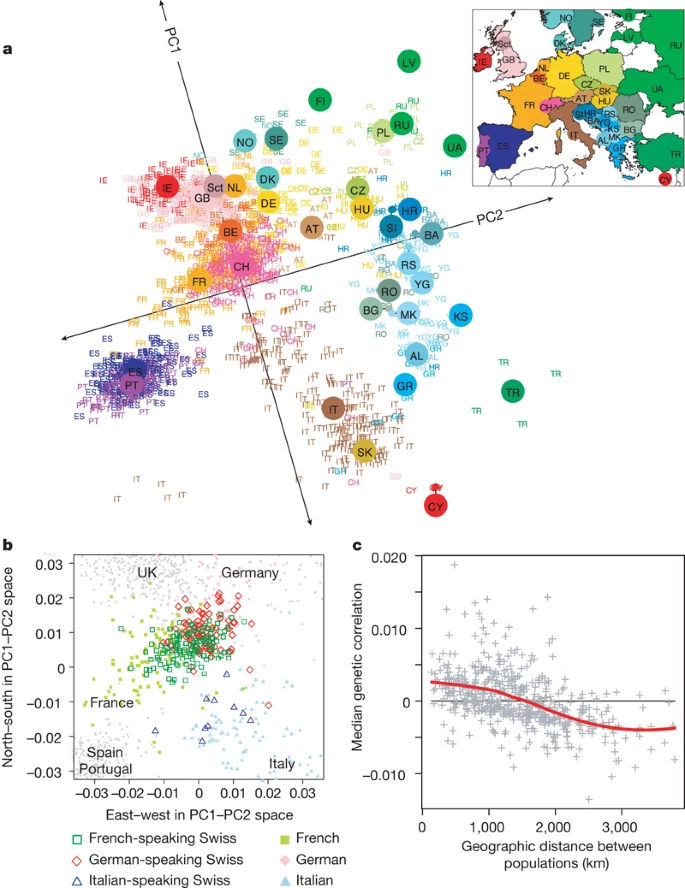
From [this article](https://www.nature.com/articles/nature07331)

So
 - Multicolinearity doesn't stop us from making predictions
 - It does stop us from interpreting the coefficients
 - PCA and similar approaches see [this](https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py) can reorganize the data to remove the multicollinearity, but we lose the simple relationships between input variables and output (which is probably why we're doing linear regression)

#### Statistical Lasso
 
Ordinary linear regression finds the coefficients $\beta$ which minimise the sum of squared errors. Lasso does the same, subject to a constraint
$$
Q = \sum_i^n (y_i - (X \beta)_i )^2 \qquad s.t. \sum_j^p |\beta_j| \leq t
$$
Which is often written using Lagrange multipliers to enforce the constraint
$$
Q = \sum_i^n (y_i - (X \beta)_i )^2 + \lambda \sum_j^p |\beta_j| 
$$
This constraint forces many of the coefficients to zero so could be good for us.

In [10]:
##fit_regularized is statsmodel's version of Lasso regression if L1_wt=1
alpha = 0.5
model = sm.OLS(y, X).fit_regularized(method='elastic_net', alpha=alpha, L1_wt=1.0, refit=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.122e+33
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                        0.00
Time:                        08:57:16   Log-Likelihood:                          1049.7
No. Observations:                  30   AIC:                                     -2097.
Df Residuals:                      29   BIC:                                     -2096.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x                   0          0        nan        nan           0           0
y              1.0000   2.98e-17   3.35e+16      0.000       1.000       1.000
n1                  0          0        nan        nan           0           0
n2                  0          0        nan        nan           0           0
n3                  0          0        nan        nan           0           0
==============================================================================
Omnibus:                        3.294   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.193   Jarque-Bera (JB):                1.909
Skew:                          -0.366   Prob(JB):                        0.385
Kurtosis:                       2.004   Cond. No.                         442.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Quite weird behaviour. Ok, let's try something else...

#### Ridge Regression
Instead of the L1 constraint (sum of absolute values) we can try an L2 constraint on the parameters (sum of squares of parameters)
$$
Q = \sum_i^n (y_i - (X \beta)_i )^2 + \lambda \sum_j^p \beta_j^2
$$

In [11]:
##fit_regularized is statsmodel's version of Ridge regression if L1_wt=0
alpha = 0.5
model = sm.OLS(y, X).fit_regularized(method='elastic_net', alpha=alpha, L1_wt=0.0, refit=True)
print(model.params)

[-0.08882379  0.58320184 -0.01164251  0.08928654  0.20257199]


Less weird, but doesn't really solve our problem and introduces other issues (it's a biased estimator, the estimate depends on a parameter, none of the coefficients are set to zero...) We can use some mix of Lasso and Ridge (called elastic net, hence the argument to the fit function) but I just don't really like these methods but perhaps I'm doing it wrong (e.g. I should probably standardize the input).

#### Making something up

In [12]:
from scipy.stats import pearsonr
import itertools

def get_correlated_sets(X, T=0.5):   
    ##compute correlations
    cols = list(X.columns)
    corrs = {}
    ucols = set()
    for i in range( 1, len(cols) ):
        for j in range(i):
            r, p = pearsonr( X[cols[i]],X[cols[j]])
            if p < 0.05 and abs(r) > T:
                corrs[ tuple( sorted((cols[i],cols[j]))) ] = abs(r);
                ucols.add(cols[i])
                ucols.add(cols[j])
    
    dcols = set(cols).difference(ucols)
    ##do an exhaustive search of all possible subsets, keep the biggest one.
    ##this is painful...
    correlated_sets = []
    while len(ucols):
        
        csize = len(correlated_sets)
        for i in range(len(ucols), 1, -1):
            corr_sets = {}
            for c in itertools.combinations( ucols, i ):
                if all([ ((x,y) in corrs or (y,x) in corrs)  for x in c for y in c if x != y]):
                    l = len(c)
                    corr_sets[c] = sum( [ corrs[tuple(sorted((x,y)))] for x in c for y in c if x != y] )/( l*(l-1) ) ##double counting
            if len(corr_sets) > 0:
                c = max(corr_sets, key=corr_sets.get)
                correlated_sets.append( set(c) )
                for k in c: ucols.remove(k)
                break

        if len(correlated_sets) == csize: break

    for e in ucols: correlated_sets.append( set([e]) )
    for e in dcols: correlated_sets.append( set([e]) )
    return correlated_sets



In [13]:
get_correlated_sets(X)

[{'n2', 'n3', 'x'}, {'y'}, {'n1'}]

What I'm trying to do here is find all the subsets which mutual have pairwise correlations of at least T. The idea would be then to choose one from each (whichever is easiest to measure!) and do the fit. You definitely lose some information this way - chosing only one representative from each set and having only imperfect correlation among elements in the sets means that any information not captured in the representative element can't improve the fit. The idea is to pick T high enough not to lose too much, but low enough not to just have singleton sets.

Honestly, standard model selection is probably for the best here - see the notes on Model Selection for Regression.

In [14]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_boston
data = load_boston()
warnings.filterwarnings('once')
import pandas as pd
%matplotlib inline
X = pd.DataFrame(data.data, columns=data.feature_names);
y = pd.DataFrame(data.target, columns=["MedHouseVal"]);
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [15]:
get_correlated_sets(X)

[{'AGE', 'DIS', 'INDUS', 'NOX', 'TAX'},
 {'CRIM', 'RAD'},
 {'LSTAT', 'RM'},
 {'ZN'},
 {'B'},
 {'CHAS'},
 {'PTRATIO'}]

 - Industry, pollution (NOX), property tax, age and distance to certain employment centres are highly correlated. I suspect these are houses in industrial areas!
 - Crime rate and highways are correlated, not sure why
 - Proportion of "lower status" population is correlated with number of rooms (presumable they can't afford many rooms in their homes!)

The original house prices paper was trying to study pollution, which is the 'NOX' variable, so I'll use that. Just arbitrarily picking the others

In [16]:
model = sm.OLS(y, X[ ['NOX', 'RAD', 'RM', 'CHAS', 'PTRATIO', 'B', 'ZN'] ]).fit()
print( model.summary() )

                                 OLS Regression Results                                
Dep. Variable:            MedHouseVal   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              1301.
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                   9.76e-316
Time:                        08:57:16   Log-Likelihood:                         -1584.9
No. Observations:                 506   AIC:                                      3184.
Df Residuals:                     499   BIC:                                      3213.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

This is a really good fit! The coefficients are also interpretable
 - NOX pollution makes prices go down
 - Highway proximity makes no difference
 - Houses with more rooms are more expensive
 - Houses next to the river are more expensive
 - Pupil teacher ratio has a small (surprisingly negative?) effect
 - Proportion of black residents has a small (surprisingly positive?) effect
 - Zoning makes no difference
This model doesn't minimise the BIC, for that see Model Selection Notes again. Note there we ignored the fact that RM and LSTAT were strongly correlated. 

In [17]:
pearsonr( X['RM'], X['LSTAT'])

PearsonRResult(statistic=-0.6138082718663957, pvalue=1.0330091329655203e-53)

#### Clustering

In [20]:
X.shape

(506, 13)

There are plenty of methods for finding groups of related things other than the greedy method implemented above. For example clustering. Usually we would cluster the data, so 506 13-dimensional vectors. But we could cluster the features, so 13 506-dimensional vectors. This is not likely to work very well but let's try it...

(13, 2)


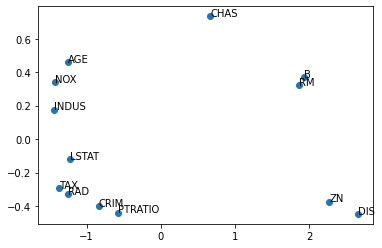

In [52]:
from sklearn.manifold import TSNE
warnings.filterwarnings('ignore') #update your scikit version Rudy

np.random.seed(12345678)

C = np.corrcoef(X.T)

tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=5, metric='precomputed')
Y = pca.fit_transform( C )
print(Y.shape)
plt.scatter(Y[:,0], Y[:,1], zorder=0)
for i,c in enumerate(X.columns):
    plt.annotate(c, xy=Y[i,:] )

plt.show()

Gives a somewhat different picture, clustering by eye!
{CHAS}
{B, RM}
{ZN, DIS}
{AGE, NOX, INDUS}
{LSTAT}
{TAX, RAD}
{CRIM, PTRATIO}

In [53]:
model = sm.OLS(y, X[ ['CHAS', 'RM', 'ZN', 'NOX', 'LSTAT', 'RAD', 'CRIM'] ]).fit()
print( model.summary() )

                                 OLS Regression Results                                
Dep. Variable:            MedHouseVal   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              1399.
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                   2.96e-323
Time:                        09:15:36   Log-Likelihood:                         -1567.3
No. Observations:                 506   AIC:                                      3149.
Df Residuals:                     499   BIC:                                      3178.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Only 3 very significant predictors: CHAS, RM and LSTAT. 